# Image to Searchable PDF 

The goal is to be able to take an image containing text and to be able to build a PDF with the text from Textract to make the PDF searchable <BR>
The first step in to install a package to help PDF creation

In [156]:
! pip install fpdf2

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


Now we import the libraries we want to use for accessing the AWS services (boto3) and for loading/displaying images (PIL) 

In [157]:
from PIL import Image
import boto3

In [158]:
# Our source image filename
src_image = "input.jpg"

Lets take a load and display the image we are going to be processing

In [159]:
im = Image.open(src_image)

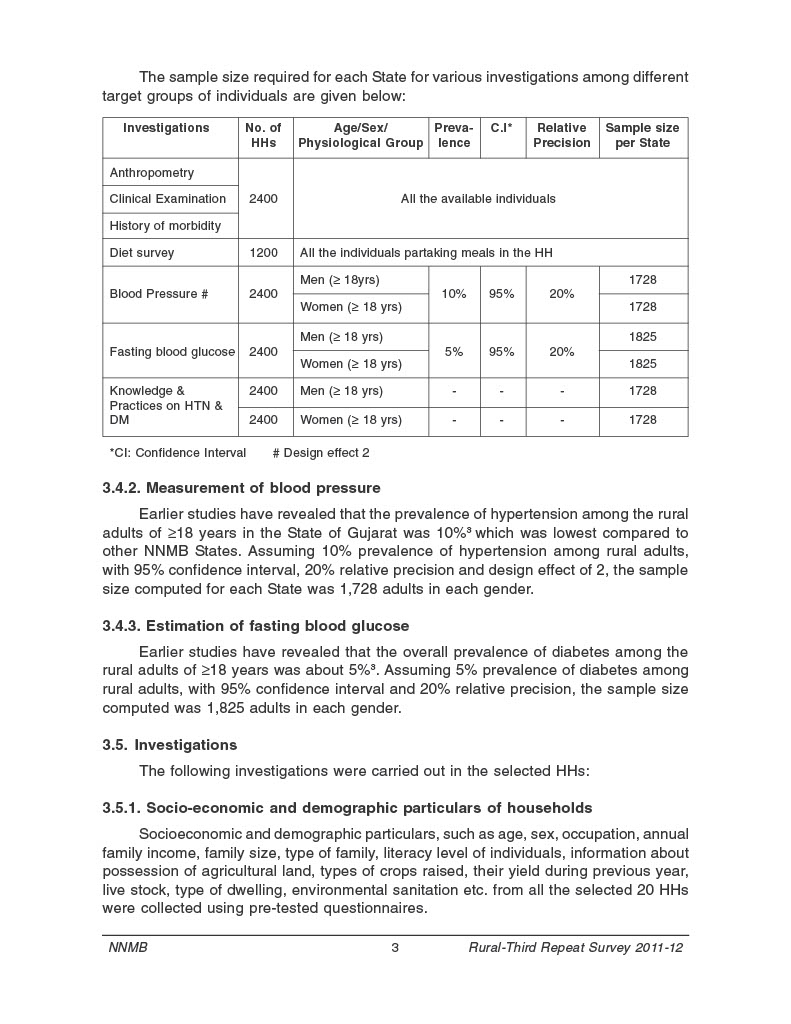

In [160]:
im

We will now import the fpdf librarires

In [161]:
from fpdf import FPDF
from fpdf import TextMode
from fpdf import XPos
from fpdf import YPos
import base64

Now we instantiate the FPDF, add a new page (letter sized) and add the image to the page

In [162]:
pdf = FPDF()
pdf.add_page(format="letter")
#pdf.set_compression(True)
pdf.image(f"{src_image}", h=pdf.eph, w=pdf.epw)

# Get the dimensions for the width and height of the page 
print(f"Width {pdf.epw} Height {pdf.eph}")
page_width = pdf.epw
page_height = pdf.eph

Width 195.89999999999998 Height 249.39999999999998


Now we send the image textract to process

In [163]:
with open(f"{src_image}","rb") as rfd:
    image_bytes = rfd.read()

textract = boto3.client('textract')
    
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'Bytes': image_bytes
    })

## If you want to extract tables as well, then you could use the following instead
#response = textract.analyze_document(
#    Document={
#        'Bytes': document.read(),
#    },
#    FeatureTypes=["TABLES"])

Now we loop through the Textract response and for each line of text, we add a text cell to the PDF using the bounding box and text from Textract<br>
NOTE we are padding the top-left corner starting point of the cell by 10 units. This is done to align the text to the text in the image

In [164]:
pad = 10.0

for line in response['Blocks']:
    if line['BlockType'] == "LINE":
        with pdf.local_context(text_mode=TextMode.INVISIBLE, line_width=2):
            
            geo = line['Geometry']['BoundingBox']
            geo_left = pad + float(geo['Left']) * page_width
            geo_top = pad + float(geo['Top']) * page_height
            geo_width = float(geo['Width'] * page_width)
            geo_height = float(geo['Height'] * page_height)
            
            pdf.set_font("helvetica", "", 11)
            pdf.set_xy(geo_left, geo_top)
            pdf.cell(txt=line['Text'], w=geo_width, h=geo_height)
          

Finally we write out the PDF

In [165]:
pdf.output("processed.pdf")